# Barriers

In [1]:
import cityImage as ci
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

In [2]:
# initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

## Barriers identification

Choose between the following methods:

* `OSMplace`, providing an OSM place name (e.g. City).
* `polygon`, providing a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter.
* `distance_from_point`, providing point coordinates (in units of latitude-longitude degrees) and setting the `distance` parameter to build the bounding box around the point.

In [3]:
place = 'Domplatz, Muenster, Germany'
download_method = 'distance_from_address'
distance = 2500

In [4]:
road_barriers = ci.road_barriers(place = place, download_method = download_method, epsg = epsg, distance = distance, 
                                 include_primary = True, include_secondary = False)
water_barriers = ci.water_barriers(place = place, download_method = download_method, distance = distance,  epsg = epsg)
railway_barriers = ci.railway_barriers(place = place, download_method = download_method, distance = distance, epsg = epsg, keep_light_rail = False)
park_barriers = ci.park_barriers(place, download_method, distance, epsg, min_area = 5000)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\barriers.py:117: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  sea = sea.unary_union


In [5]:
barriers = pd.concat([road_barriers, water_barriers, railway_barriers, park_barriers], ignore_index=True)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

**Visualisation**

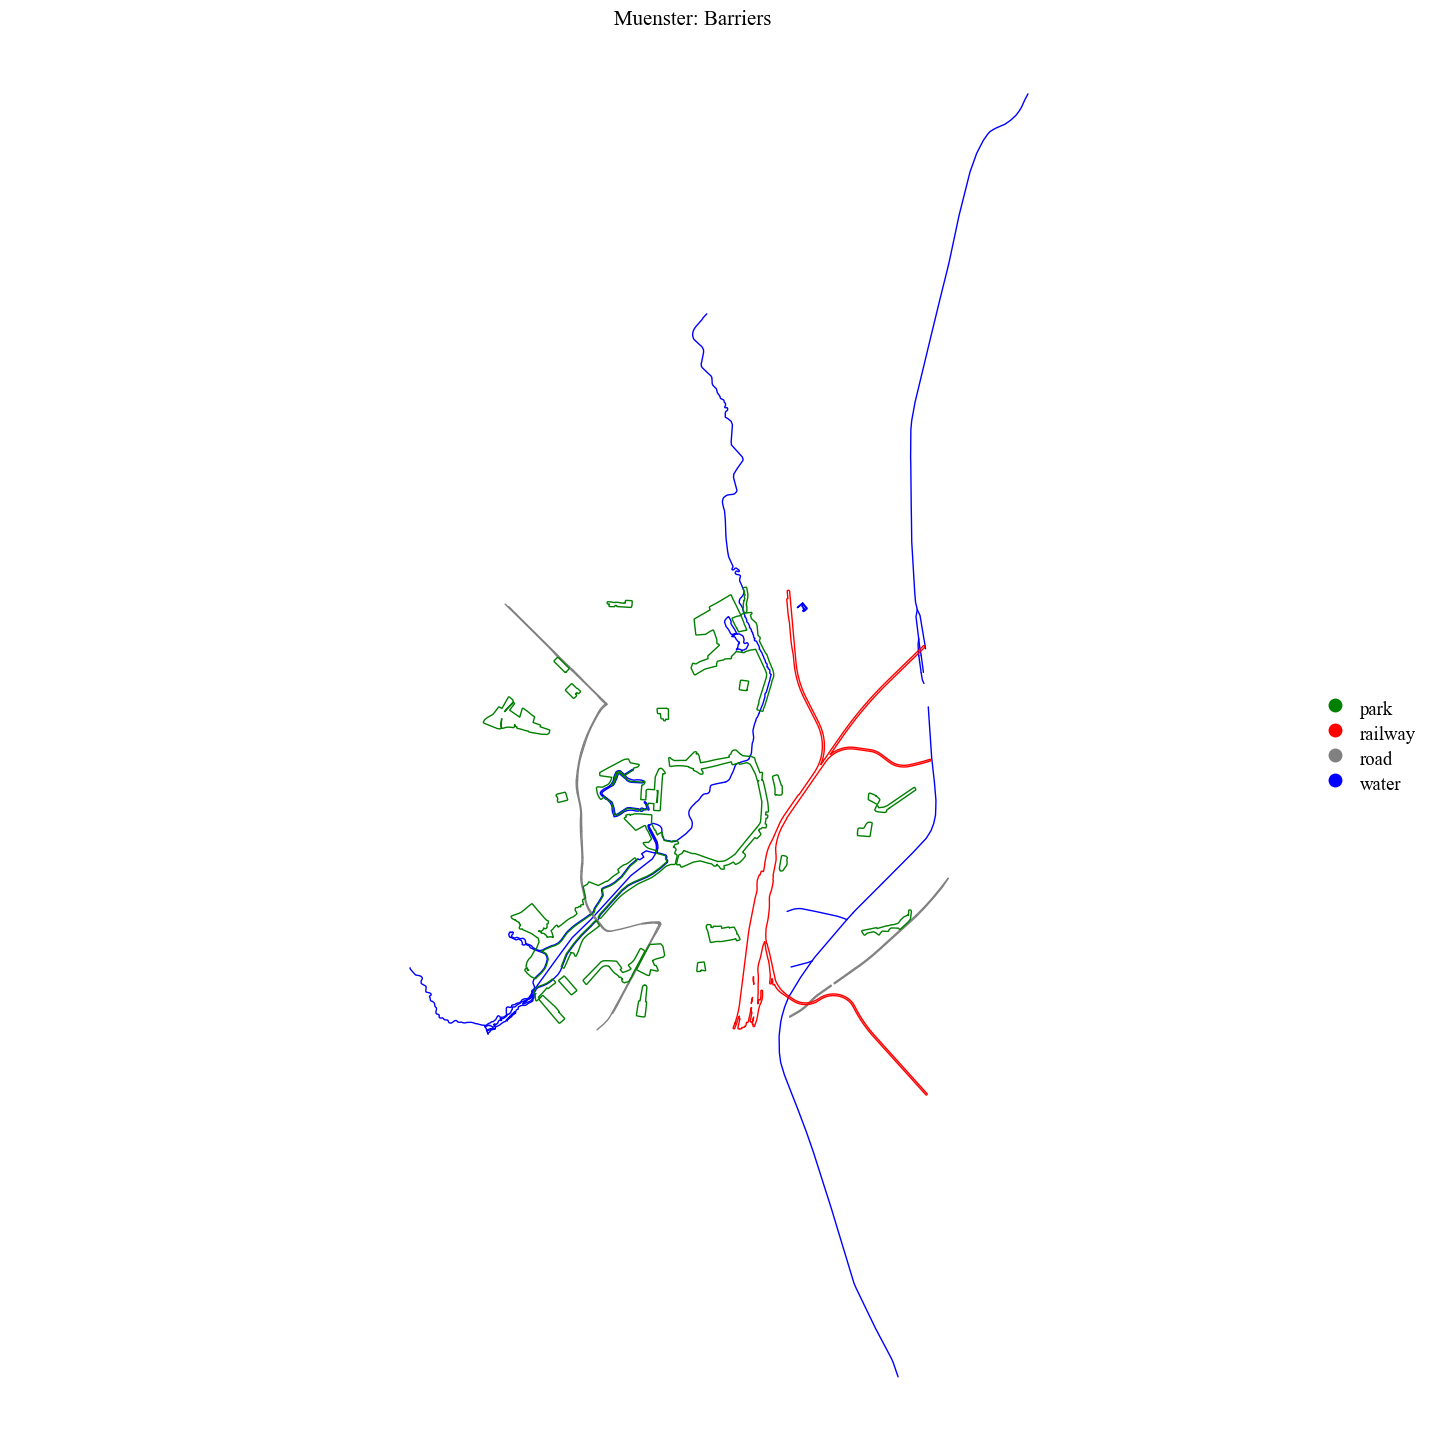

In [6]:
barriers.sort_values(by = 'barrier_type', ascending = False, inplace = True)  
colors = ['green', 'red', 'gray', 'blue']

cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(gdf = barriers, column = 'barrier_type', black_background = False, title = city_name+': Barriers', 
                  legend = True, cmap = cmap)

## Incorporating Barriers into the Street Network
This is an optional step that allows modelling the effect of barriers on pedestrian movement, for exmaple, in agent-based modelling, or in route-choice modelling.

### Download the street network

Choose between the following methods:

* `OSMplace`, providing an OSM place name (e.g. City).
* `polygon`, providing a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter.
* `distance_from_point`, providing point coordinates (in units of latitude-longitude degrees) and setting the `distance` parameter to build the bounding box around the point.

Downloading the graph and cleaning it (see the notebook *01-Nodes_Paths_fromOSM* for details on the cleaning process)

In [7]:
# download graph and clean (see network notebook for details on the cleaning process)

place = 'Domplatz, Muenster, Germany'
download_method = 'distance_from_address'
distance = 2500
nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            self_loops = True, same_vertexes_edges = True)

### (or) Load it from local path

In [ ]:
input_path = '../data/'+city_name
nodes_graph = gpd.read_file(input_path+'_nodes.gpkg')
edges_graph = gpd.read_file(input_path+'_edges.gpkg')

nodes_graph.index, edges_graph.index  = nodes_graph.nodeID, edges_graph.edgeID
nodes_graph.index.name, edges_graph.index.name  = None, None

**Visualisation**

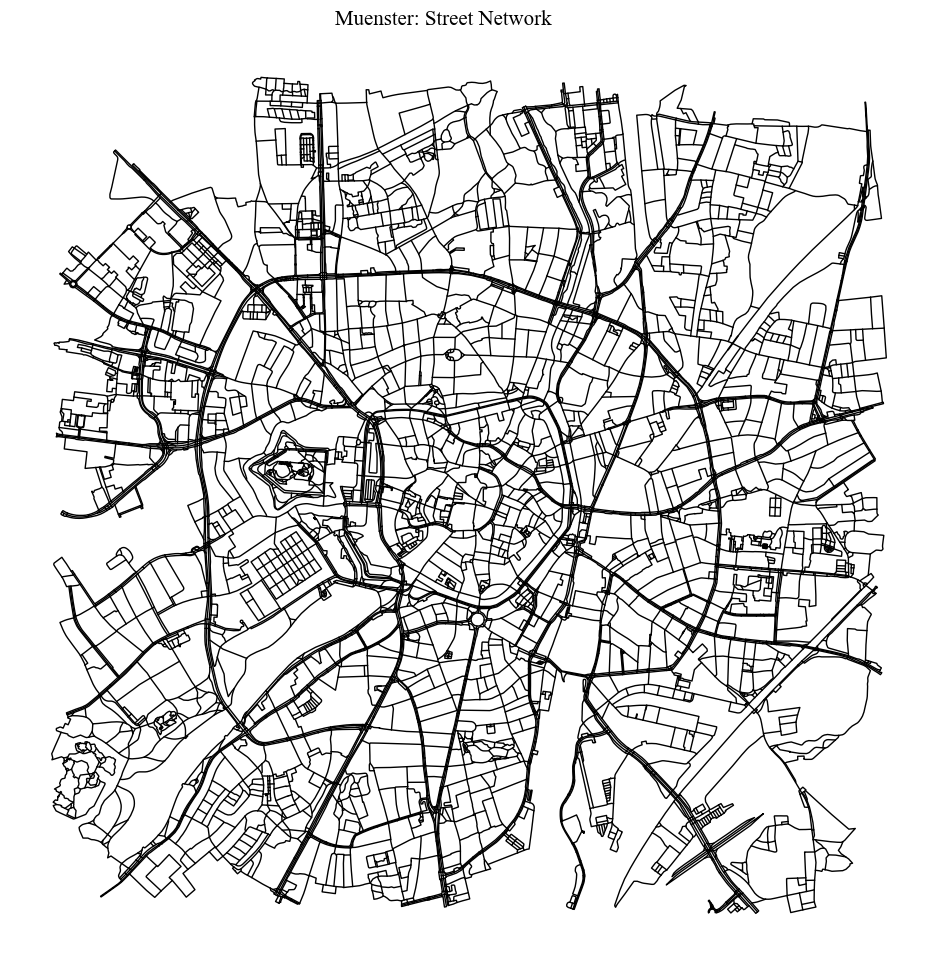

In [8]:
fig = ci.plot_gdf(edges_graph, black_background = False, geometry_size = 1.0, alpha = 1.0, 
                 color = 'black', title = city_name+': Street Network', figsize = (10,10))

## Assigning barriers to street segments
**Type of barriers**

Choose between the following methods:
* *Positive barriers* - pedestrian perspective: Waterbodies, Parks.
* *Negative barriers* - pedestrian perspective: Major Roads, Railway Structures.
* *Structuring barriers* - barriers which structure and shape the image of the city: Waterbodies, Major roads, Railways.

In [9]:
# clipping barriers to case study area
envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(edges_graph.unary_union.envelope)]

### Street Segments *Along* and *Within* Positive Barriers

In [10]:
sindex = edges_graph.sindex
# rivers
edges_graph = ci.along_water(edges_graph, barriers_within)
# parks
edges_graph = ci.along_within_parks(edges_graph, barriers_within)
# altogheter
edges_graph['p_barr'] = edges_graph['a_rivers']+edges_graph['w_parks']
edges_graph['p_barr'] = edges_graph.apply(lambda row: list(set(row['p_barr'])), axis = 1)

### Street Segments *Along* Negative Barriers

In [11]:
tmp = barriers_within[barriers_within['barrier_type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: ci.barriers_along(row['edgeID'], edges_graph, tmp, sindex,
                                            offset = 25), axis = 1)

### Street Segments *Crossing* any kind of barrier but parks: Structuring Barriers

In [12]:
edges_graph = ci.assign_structuring_barriers(edges_graph, barriers_within)

**Visualisation**

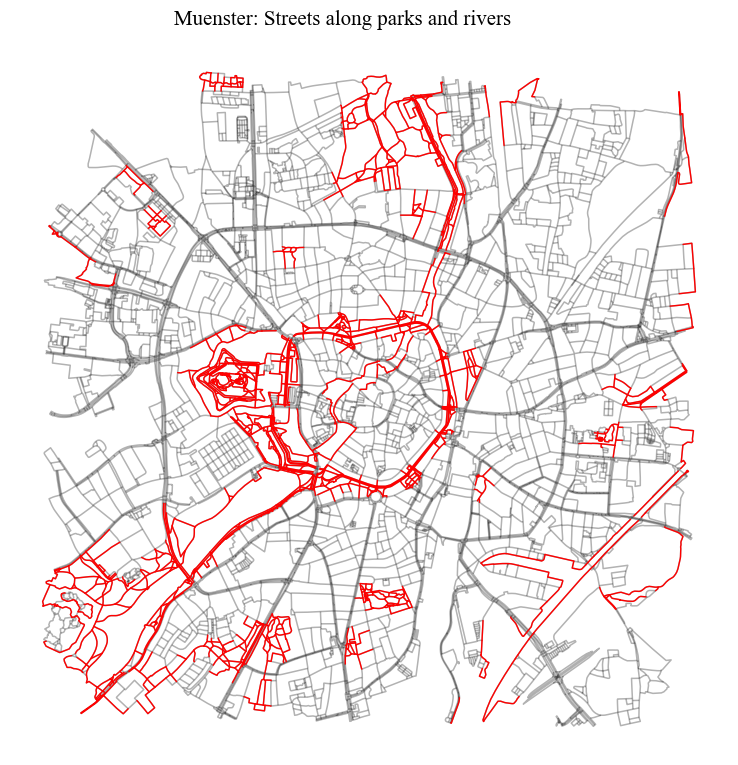

In [13]:
# positive barriers
edges_graph['p_bool'] = edges_graph.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.p_bool == True].copy()

# base map
base_map_dict = {'base_map_gdf': edges_graph, 'base_map_alpha' : 0.3, 'base_map_color' : 'black'}
fig = ci.plot_gdf(tmp, black_background = False, figsize = (8, 8), color = 'red', title = city_name+': Streets along parks and rivers', 
              legend = False, **base_map_dict)

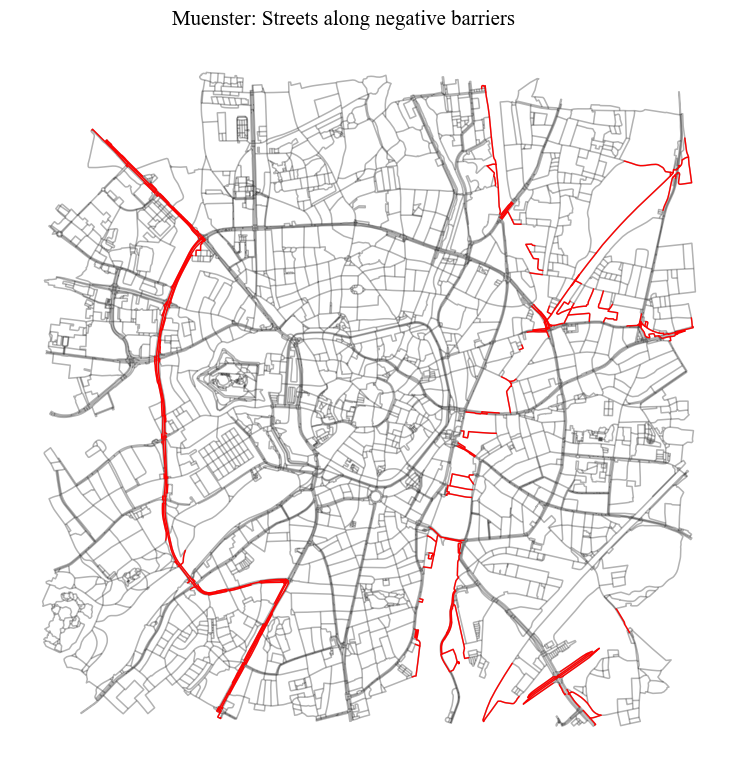

In [14]:
# negative barriers
edges_graph['n_bool'] = edges_graph.apply(lambda row: True if len(row['n_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.n_bool == True].copy()

# base map
fig = ci.plot_gdf(tmp, black_background = False, figsize = (8, 8), color = 'red', title = city_name+': Streets along negative barriers',
              legend = False, **base_map_dict)

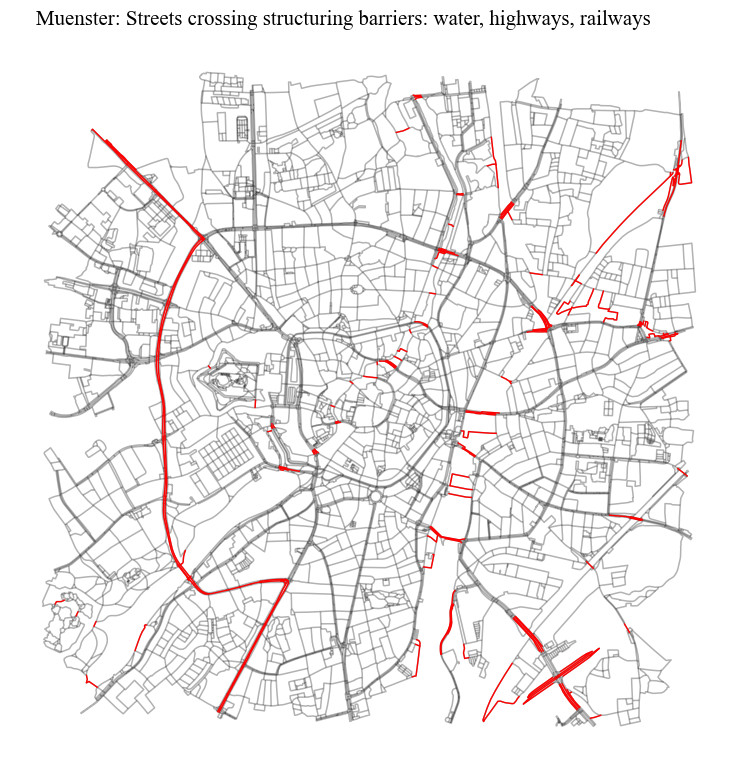

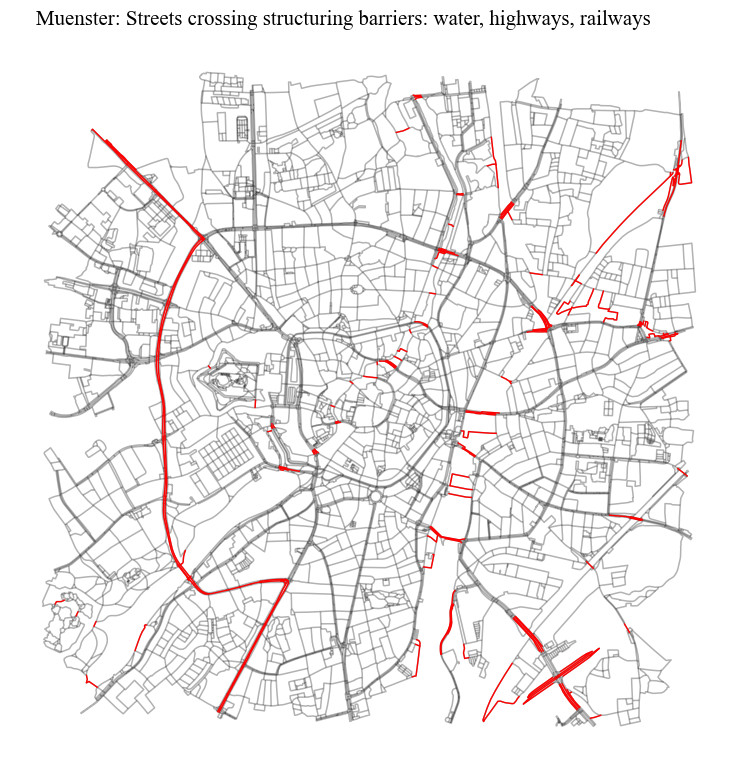

In [15]:
# separating barriers
tmp = edges_graph[edges_graph.sep_barr == True].copy()
ci.plot_gdf(tmp, black_background = False, figsize = (8, 8),  color = 'red', 
            title = city_name+': Streets crossing structuring barriers: water, highways, railways',
             **base_map_dict)

**Exporting**

In [16]:
# saving barriers_gdf
output_path = '../output/'+city_name
barriers.to_file(output_path+"_barriers.gpkg", driver='GPKG')

# converting list fields to string
to_convert = ['a_rivers', 'w_parks','n_barr', 'p_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: 
    edges_graph_string[column] = edges_graph_string[column].astype(str)

edges_graph_string.to_file(output_path+"_edges_ped.gpkg", driver='GPKG')
nodes_graph.to_file(output_path+'_nodes_ped.gpkg', driver='GPKG')